# Chocolate Rating Analysis

# Web scraping data to then process, clean, etc. in the notebook.

In [1]:
# import warnings
# warnings.filterwarnings('ignore')

# from requests import get
# from bs4 import BeautifulSoup
# import pandas as pd
# from selenium import webdriver
# import chromedriver_autoinstaller
# def create_driver(headless=True):
#     driver = chromedriver_autoinstaller.install(cwd=True)
#     chrome_options = webdriver.ChromeOptions()     
#     if headless:
#         chrome_options.add_argument("--headless")
#     driver = webdriver.Chrome(driver, 
#                              chrome_options = chrome_options)
#     return driver
# driver = create_driver()

In [2]:
# driver.get("http://flavorsofcacao.com/chocolate_database.html")

In [3]:
# div_id = "spryregion1"

# html = driver.page_source
# soup = BeautifulSoup(html)
# div = soup.find('div', {'id':div_id})
# # div

# table = div.find('table')
# table


In [4]:
# pd.read_html(str(table))[0]

In [5]:
# df.to_csv('../../../data/chocolate.csv', index=False)

# Importing Necessary Python Libraries 

In [96]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import plot_confusion_matrix, auc, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from imblearn.over_sampling import SMOTE
from collections import Counter

all_data = pd.read_csv('../../../data/chocolate.csv')
all_data.head()

,REF,Company (Manufacturer),Company Location,Review Date,Country of Bean Origin,Specific Bean Origin or Bar Name,Cocoa Percent,Ingredients,Most Memorable Characteristics,Rating
0,2454,5150,U.S.A.,2019,Madagascar,"Bejofo Estate, batch 1",76%,"3- B,S,C","cocoa, blackberry, full body",3.75
1,2458,5150,U.S.A.,2019,Dominican Republic,"Zorzal, batch 1",76%,"3- B,S,C","cocoa, vegetal, savory",3.50
2,2454,5150,U.S.A.,2019,Tanzania,"Kokoa Kamili, batch 1",76%,"3- B,S,C","rich cocoa, fatty, bready",3.25
3,797,A. Morin,France,2012,Peru,Peru,63%,"4- B,S,C,L","fruity, melon, roasty",3.75
4,797,A. Morin,France,2012,Bolivia,Bolivia,70%,"4- B,S,C,L","vegetal, nutty",3.50


# Data Cleaning 

### Replacing column spaces with underscores and lower casing column names for simplicity when calling them. 

In [97]:
#breaking away from original dataset and creating a copy to maintain the original structure as "all_data"
df = all_data.copy()

In [98]:
#removing parenthesis and spaces from columns 
df.columns = df.columns.str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.lower()

#removing percent signs from row cocoa_percent
df = df.replace("%", "", regex=True)
# turning percentage of cocoa into a float
df["cocoa_percent"] = df.cocoa_percent.astype(float)

df.head()

,ref,company_manufacturer,company_location,review_date,country_of_bean_origin,specific_bean_origin_or_bar_name,cocoa_percent,ingredients,most_memorable_characteristics,rating
0,2454,5150,U.S.A.,2019,Madagascar,"Bejofo Estate, batch 1",76.0,"3- B,S,C","cocoa, blackberry, full body",3.75
1,2458,5150,U.S.A.,2019,Dominican Republic,"Zorzal, batch 1",76.0,"3- B,S,C","cocoa, vegetal, savory",3.50
2,2454,5150,U.S.A.,2019,Tanzania,"Kokoa Kamili, batch 1",76.0,"3- B,S,C","rich cocoa, fatty, bready",3.25
3,797,A. Morin,France,2012,Peru,Peru,63.0,"4- B,S,C,L","fruity, melon, roasty",3.75
4,797,A. Morin,France,2012,Bolivia,Bolivia,70.0,"4- B,S,C,L","vegetal, nutty",3.50


# Exploratory Data Analysis: 

Determining the goals for the features in terms of which to compare to the target variable and the take aways for each feaure

## Looking into the relationships of chocolate characteristics and company location. 

### Evaluating the most memorable characteristics 

In [99]:
# over 2300 combinations of flavors 
df.most_memorable_characteristics.value_counts().sum()

2362

In [100]:
df.most_memorable_characteristics.value_counts()

creamy, nutty, cocoa              4
spicy, cocoa                      4
sandy, sweet, cocoa               3
cherry, rich choco                3
sweet, marshmallow                3
                                 ..
very sweet, coffee, mild sour     1
sandy, citrus                     1
fatty, powdery, nut, sl. Burnt    1
sandy, sweet, fruity              1
light color, dirty, musty         1
Name: most_memorable_characteristics, Length: 2320, dtype: int64

### Breaking up flavors individually and determining the weighted average (weighted_occurance * rating) for the top 25 flavors

In [101]:
# word list returns words from the dataframe that have been split
word_list = [word.strip().replace(',', '').replace('"', '') for word in " ".join(df.most_memorable_characteristics).split()]

word_counts = np.unique(word_list, return_counts=True)
word_c = np.array([word_counts[0], word_counts[1]])
word_df = pd.DataFrame(word_c.T, columns=['word', 'count'])
word_df.sort_values(by='count', ascending=False)

,word,count
360,molasses,90
564,toffee,9
159,cream,9
89,buttery,9
282,hazelnut,9
...,...,...
385,noticeable,1
51,berrypowerful,1
155,cooling,1
382,not,1


### Checking to see how many times each flavor appears

In [102]:
count = 0
for c in df.most_memorable_characteristics.values:
    if 'sweet' in [x.strip().replace(',', '').replace('"', '') for x in c.split(', ')]:
        count += 1
count

248

In [103]:
word_count_list = Counter(word_list).most_common(25)
word_count_list

[('cocoa', 356),
 ('sweet', 287),
 ('nutty', 260),
 ('fruit', 236),
 ('roasty', 210),
 ('mild', 208),
 ('sour', 185),
 ('earthy', 185),
 ('creamy', 183),
 ('intense', 166),
 ('sandy', 161),
 ('fatty', 157),
 ('floral', 150),
 ('spicy', 144),
 ('rich', 141),
 ('bitter', 120),
 ('off', 104),
 ('vanilla', 101),
 ('molasses', 90),
 ('coffee', 87),
 ('woody', 85),
 ('spice', 79),
 ('sticky', 78),
 ('berry', 72),
 ('tart', 70)]

In [104]:
x = [count_list[0] for count_list in word_count_list]
y = [count_list[1] for count_list in word_count_list]

In [105]:
cleaned_word_list = []

#grabbing an arry of charcteristics, splitting (sepparating them by columns) and cleaning them
for char in df['most_memorable_characteristics'].values:
    l = char.split(', ')
    clean_list = [word.replace(',', '').replace('"', '').strip() for word in l] 
    cleaned_word_list.append(clean_list)
     
#assigning the clean word list to the memorable char column
df['memorable_characteristics_list'] = cleaned_word_list

In [106]:
# grabbing the shape of the full dataframe
num_rows = df.shape[0]

# creating an empty dictionary to fill with the chocolate characteristics and their weighted averages 
weighted_chars = {}

for word in x:
    #the df[df is returning the values associated with the list comprehension - lambda rather than a boolean
    word_df = df[df['memorable_characteristics_list'].apply(lambda lst: word in lst)]
    avg_rating = word_df['rating'].mean()
    weight = len(word_df) / num_rows
    weighted_chars[word] = avg_rating * weight 

In [107]:
#turning the dictionary into a dataframe
sorted_weighted_chars_df = pd.DataFrame(list(zip(weighted_chars.keys(), weighted_chars.values())), columns=['chocolate_char', 'weighted_rating']).sort_values(by='weighted_rating',ascending=False)

#ensuring that the chocolate characteristics are sorted according to their weighted averages
sorted_weighted_chars_df.head(3)

,chocolate_char,weighted_rating
2,nutty,0.338696
1,sweet,0.319750
0,cocoa,0.304509


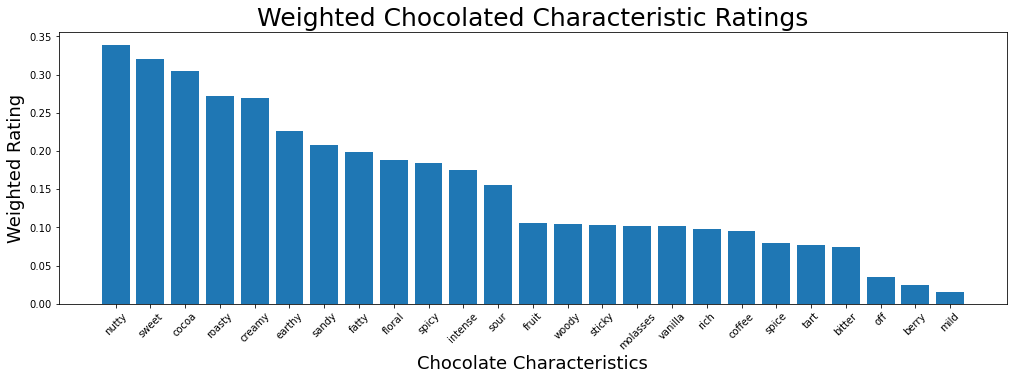

In [108]:
# Plotting the most memorable characteristics

import matplotlib.pyplot as plt

x = sorted_weighted_chars_df['chocolate_char']

y = sorted_weighted_chars_df['weighted_rating']

fig, ax = plt.subplots(figsize=(17,5))
plt.xticks(rotation = 45)
plt.title('Weighted Chocolated Characteristic Ratings', fontsize=25)
plt.xlabel('Chocolate Characteristics', fontsize=18)
plt.ylabel('Weighted Rating', fontsize=18)

plt.bar(x,y)
plt.show()

* The chocolate characteristics appears to have visual groups in relation to the weighted ratings. It might be helpful to group them before modeling

* It also appears that certain chocolate bars that were sold the most contain characteristics that were not highly rated. 

## Evaluating the Company Location

### Inspecting the company location's weighted average in relation to rating

In [109]:
# Average rating of each country. ex: 'Puerto Rico': 2.625
average_ratings_company_location = df.groupby('company_location')['rating'].mean().sort_values().to_dict()


In [110]:
# Percentage of Country appearances. ex: 'U.S.A.': 0.42929720575783237
company_location_counts = df['company_location'].value_counts(normalize=True).to_dict()


### creating a dictionary of the country that the chocolate bars were sold in as keys and their weighted ratings as the values 

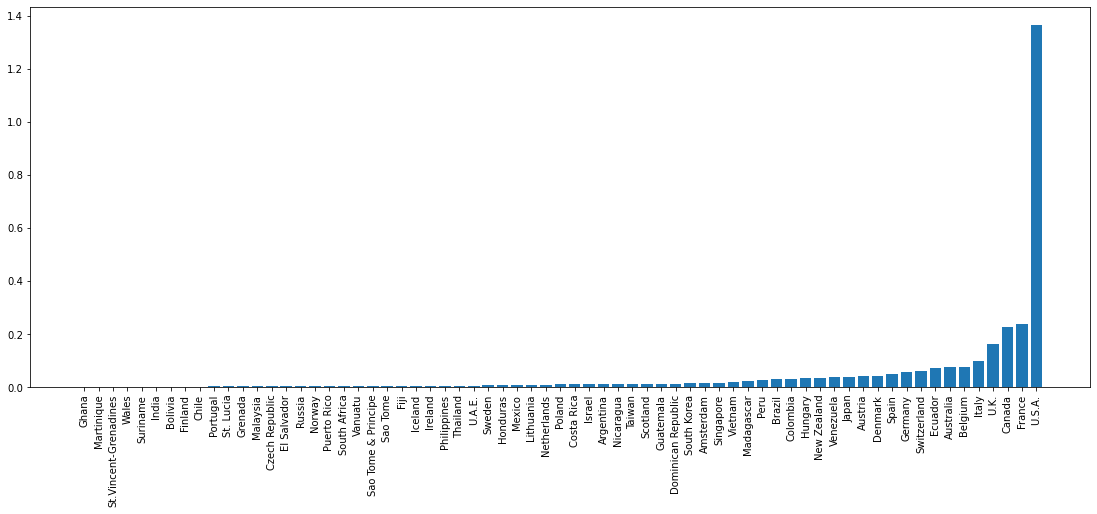

In [111]:
#creating a weighted average number of appearances * rating
companies_loc = df.company_location.unique()


#Inspecting the weighting average of the appearance of countries and the rating 

#ex: country appearance percentage * country average rating 
weighted_rating = []
for company in companies_loc:
    count = company_location_counts[company]
    rating = average_ratings_company_location[company]
    weighted_rating.append(count * rating)
    
sorted_comp_rating_vals = sorted(list(zip(weighted_rating, companies_loc)))
x = [val[1] for val in sorted_comp_rating_vals]
y = [val[0] for val in sorted_comp_rating_vals]

# Creating a vizualization for the relationships weighted ratings compared with countries 
plt.figure(figsize=(19,7))
plt.bar(x, y)
plt.xticks(rotation=90);


### Placing the countries into groups of low, medium, and high ratings and breaking them based on their indexes and renaming them as 1, 2, and 3. 

In [112]:
#Matching the country weighted ratings with each country.
#company_loc -> unique country non-repeated 
group_df = pd.DataFrame(list(zip(companies_loc, weighted_rating)), columns=['country', 'weighted_rating'])
group_df.head()

,country,weighted_rating
0,U.S.A.,1.364204
1,France,0.239522
2,Fiji,0.005504
3,Vanuatu,0.004657
4,Ecuador,0.074619


### using q-cut with a value of 3

In [113]:
group_df['weighted_company_bins'] = pd.qcut(group_df['weighted_rating'], 
                                            labels=['low', 'middle', 'high'], q=3)


In [114]:
group_df.head(2)

,country,weighted_rating,weighted_company_bins
0,U.S.A.,1.364204,high
1,France,0.239522,high


In [115]:
weighted_company_bins = group_df.set_index('country')['weighted_company_bins'].to_dict()

In [116]:
df['company_loc_bins'] = df['company_location'].map(weighted_company_bins)

### changing the high, middle, low into the values 1,2,and 3 to avoid later OneHotEncoding

In [117]:
company_bin = []
for c in df['company_loc_bins'].values:     # -> ex: 'high', 'high', 'high', ..., 'high', 'high', 'high'
    if c == 'low':
        company_bin.append(1)
    elif c == 'middle':
        company_bin.append(2)
    else:
        company_bin.append(3)

#ensuring that 
df['company_loc_bins'] = company_bin
df['company_loc_bins'].value_counts()

3    2119
2     182
1      61
Name: company_loc_bins, dtype: int64

## Determining weighted ratings of country bean origin 

**thought process:**

* group specific_bean_origin_or_bar_name with country_location 
    - compare with rating and group according to high/low.
    
* group country_of_bean_origin with country_location
    - compare with rating and group according to high/low. 

<AxesSubplot:>

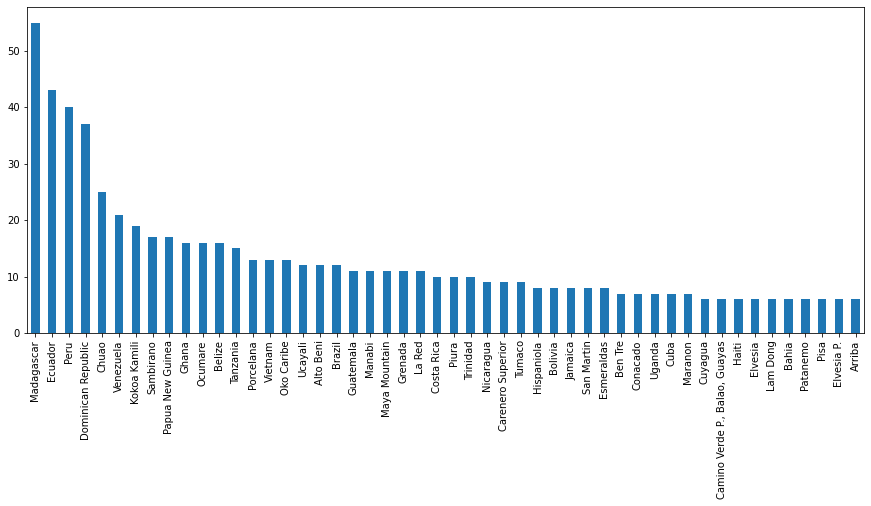

In [118]:
df['specific_bean_origin_or_bar_name'].value_counts()[:50].plot(kind='bar', figsize=(15,6))

* Seeing that Madagascar - the Dominican Republic indicates that they are prioritizing making the chocolate beans, but not creating the chocolate bars. It would be intersting to group them with where the chocolate bars are made and compare them with rating.

In [119]:
df[df.company_location == 'U.S.A.'].country_of_bean_origin.value_counts()

Dominican Republic    140
Peru                  100
Ecuador                83
Venezuela              82
Madagascar             68
Blend                  54
Bolivia                48
Belize                 47
Tanzania               43
Nicaragua              31
Guatemala              29
U.S.A.                 28
Costa Rica             27
Brazil                 25
Ghana                  22
Vietnam                22
Trinidad               18
Colombia               17
Mexico                 16
Jamaica                14
Honduras               13
Papua New Guinea       13
India                  12
Uganda                 11
Haiti                  11
Fiji                    8
Indonesia               5
Philippines             4
Sierra Leone            4
Liberia                 3
Ivory Coast             3
Puerto Rico             3
Congo                   2
Grenada                 2
Solomon Islands         2
Nigeria                 2
Cameroon                1
Panama                  1
Name: countr

In [120]:
df[df.company_location == 'U.S.A.'].specific_bean_origin_or_bar_name.value_counts()

Dominican Republic                              25
Ecuador                                         22
Madagascar                                      20
Peru                                            17
Kokoa Kamili                                    15
                                                ..
Dark, Central and S. America                     1
Camino Verde P., Balao, Guayas, 2014, b. 001     1
La Masica, Batch 7, FHIA                         1
Capistrano*                                      1
Pinchincha, Mindo, Coop Nueva Esper., 2015       1
Name: specific_bean_origin_or_bar_name, Length: 678, dtype: int64

<AxesSubplot:>

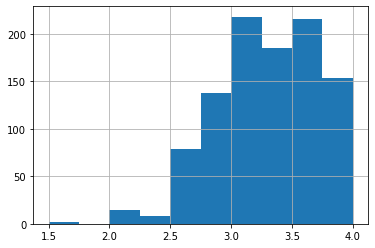

In [121]:
df[df.company_location == 'U.S.A.'].rating.hist()

* it is apparent that U.S.A has a high variance in terms of ratings and would need to be broken into groups of low and high ratings. 

**CURRENTLY HAVE:**

- Weighted country location rating (count * rating)

Bean origin 

Spacifin Bean origin 

In [122]:
df.head(2)

,ref,company_manufacturer,company_location,review_date,country_of_bean_origin,specific_bean_origin_or_bar_name,cocoa_percent,ingredients,most_memorable_characteristics,rating,memorable_characteristics_list,company_loc_bins
0,2454,5150,U.S.A.,2019,Madagascar,"Bejofo Estate, batch 1",76.0,"3- B,S,C","cocoa, blackberry, full body",3.75,"[cocoa, blackberry, full body]",3
1,2458,5150,U.S.A.,2019,Dominican Republic,"Zorzal, batch 1",76.0,"3- B,S,C","cocoa, vegetal, savory",3.50,"[cocoa, vegetal, savory]",3


### Grouping the bean origin and specific bean origin with the company location's rating 

In [123]:
# Average rating of each country bean origin. ex: 'Puerto Rico': 2.625
average_ratings_bean_origin = df.groupby('country_of_bean_origin')['rating'].mean().sort_values().to_dict()


In [124]:
#Returning the country appearances as a normalized value (percentage):
# ex: 'U.S.A.': 0.42929720575783237

origin_location_counts = df['country_of_bean_origin'].value_counts(normalize=True).to_dict()


### creating a dictionary of the bean origin as keys and their weighted ratings as the values 

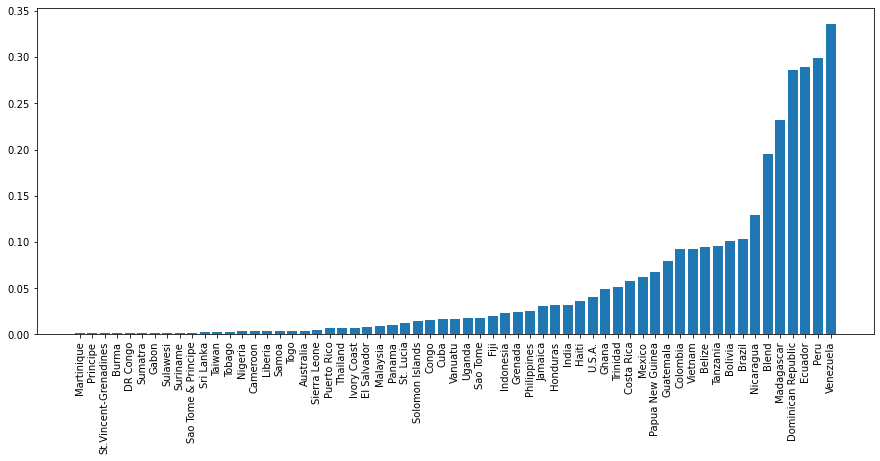

In [125]:
#Inspecting the weighting average ratings of the country of bean origins

#Returning the unique countries from the original dataframe   -> #ex:'Madagascar', 'Dominican Republic', 'Tanzania', 'Peru', 'Bolivia'
origin_loc = df.country_of_bean_origin.unique()  

#creating an list to place the name and weighted average ratings into 
weighted_bean_rating = []

#looping through a mathmetical computation that finds the weighted rating 
for place in origin_loc:
    country_count = origin_location_counts[place]
    country_rating = average_ratings_bean_origin[place]
    #taking the maen rating and * by the country appearance percentage 
    weighted_bean_rating.append(country_count * country_rating)
    
# sorting the values and placing them into a dictionary of {rating,location}
sort_weight_origin_rating = sorted(list(zip(weighted_bean_rating, origin_loc)))

# creating a for loop that takes the weighted rating and sets them equal to x
x = [w[1] for w in sort_weight_origin_rating]
# creating a for loop that takes the weighted rating and sets them equal to y
y = [w[0] for w in sort_weight_origin_rating]

# Creating a vizualization for the relationships weighted ratings compared with countries 
plt.figure(figsize=(15,6))
plt.bar(x, y)
plt.xticks(rotation=90);

In [126]:
df.head(1)

,ref,company_manufacturer,company_location,review_date,country_of_bean_origin,specific_bean_origin_or_bar_name,cocoa_percent,ingredients,most_memorable_characteristics,rating,memorable_characteristics_list,company_loc_bins
0,2454,5150,U.S.A.,2019,Madagascar,"Bejofo Estate, batch 1",76.0,"3- B,S,C","cocoa, blackberry, full body",3.75,"[cocoa, blackberry, full body]",3


In [127]:
#Matching the country weighted ratings with each country.
#company_loc -> unique country non-repeated 
group_df_bean = pd.DataFrame(list(zip(origin_loc, weighted_bean_rating)), columns=['country', 'weighted_rating'])
group_df_bean.head()

,country,weighted_rating
0,Madagascar,0.232218
1,Dominican Republic,0.286452
2,Tanzania,0.095364
3,Peru,0.299217
4,Bolivia,0.101185


In [128]:

group_df_bean['weighted_company_bins'] = pd.qcut(group_df['weighted_rating'], 
                                            labels=['low', 'middle', 'high'], q=3)

#creating a dictionary to map it to the MAIN dataframe 'df'
weighted_company_bins = group_df.set_index('country')['weighted_company_bins'].to_dict()

df['bean_origin_bins'] = df['company_location'].map(weighted_company_bins)

### changing the high, middle, low into the values 1,2,and 3 to avoid later OneHotEncoding

In [129]:
company_bin = []
for c in df['bean_origin_bins'].values:     # -> ex: 'high', 'high', 'high', ..., 'high', 'high', 'high'
    if c == 'low':
        company_bin.append(1)
    elif c == 'middle':
        company_bin.append(2)
    else:
        company_bin.append(3)

#ensuring that 
df['bean_origin_bins'] = company_bin
df['bean_origin_bins'].value_counts()


3    2119
2     182
1      61
Name: bean_origin_bins, dtype: int64

In [130]:
df.head(2)

,ref,company_manufacturer,company_location,review_date,country_of_bean_origin,specific_bean_origin_or_bar_name,cocoa_percent,ingredients,most_memorable_characteristics,rating,memorable_characteristics_list,company_loc_bins,bean_origin_bins
0,2454,5150,U.S.A.,2019,Madagascar,"Bejofo Estate, batch 1",76.0,"3- B,S,C","cocoa, blackberry, full body",3.75,"[cocoa, blackberry, full body]",3,3
1,2458,5150,U.S.A.,2019,Dominican Republic,"Zorzal, batch 1",76.0,"3- B,S,C","cocoa, vegetal, savory",3.50,"[cocoa, vegetal, savory]",3,3


## Determining the weighted ratings of the specific bean origin 

In [131]:
# Average rating of each country. ex: 'Puerto Rico': 2.625
average_ratings_specific_bean_origin = df.groupby('specific_bean_origin_or_bar_name')['rating'].mean().sort_values().to_dict()


In [132]:
# Percentage of Country appearances. ex: 'U.S.A.': 0.42929720575783237
specific_origin_location_counts = df['specific_bean_origin_or_bar_name'].value_counts(normalize=True).to_dict()


In [133]:
df.specific_bean_origin_or_bar_name.value_counts()

Madagascar                                    55
Ecuador                                       43
Peru                                          40
Dominican Republic                            37
Chuao                                         25
                                              ..
Arauca, batch 280                              1
Papaua New Guinea                              1
Akesson Estate, batch 10                       1
Ham Luong                                      1
Pinchincha, Mindo, Coop Nueva Esper., 2015     1
Name: specific_bean_origin_or_bar_name, Length: 1475, dtype: int64

### creating a dictionary of the specific bean origin as keys and their weighted ratings as the values 

In [134]:
#Inspecting the weighting average ratings of the country of bean origins

#Returning the unique countries from the original dataframe   -> #ex:'Madagascar', 'Dominican Republic', 'Tanzania', 'Peru', 'Bolivia'
most_common_bean_loc = df.specific_bean_origin_or_bar_name.unique()  

#creating an list to place the name and weighted average ratings into 
weighted_bean_rating = []

#looping through a mathmetical computation that finds the weighted rating 
for place in most_common_bean_loc:
    country_count = specific_origin_location_counts[place]
    country_rating = average_ratings_specific_bean_origin[place]
    
    #taking the maen rating and * by the country appearance percentage 
    weighted_bean_rating.append(country_count * country_rating)
    
# sorting the values and placing them into a dictionary of {rating,location}
sort_weight_specificOrigin_rating = sorted(list(zip(weighted_bean_rating, most_common_bean_loc)))

# creating a for loop that takes the weighted rating and sets them equal to x
x = [w[1] for w in sort_weight_origin_rating]
# creating a for loop that takes the weighted rating and sets them equal to y
y = [w[0] for w in sort_weight_origin_rating]

In [135]:
#Matching the country weighted ratings with each country.
#company_loc -> unique country non-repeated 
group_df_specific_origin = pd.DataFrame(list(zip(origin_loc, weighted_bean_rating)), columns=['country', 'weighted_rating'])
group_df_specific_origin.head()

,country,weighted_rating
0,Madagascar,0.001588
1,Dominican Republic,0.001482
2,Tanzania,0.001376
3,Peru,0.049428
4,Bolivia,0.010161


### setting specific origin to values of low, middle, and high

In [136]:

group_df_specific_origin['weighted_specific_bins'] = pd.qcut(group_df['weighted_rating'], 
                                            labels=['low', 'middle', 'high'], q=3)

#creating a dictionary to map it to the MAIN dataframe 'df'
weighted_company_bins = group_df_specific_origin.set_index('country')['weighted_specific_bins'].to_dict()

df['weighted_specific_origin_bins'] = df['specific_bean_origin_or_bar_name'].map(weighted_company_bins)

### changing the high, middle, low into the values 1,2,and 3 to avoid later OneHotEncoding


In [137]:

company_bin = []
for c in df['weighted_specific_origin_bins'].values:     # -> ex: 'high', 'high', 'high', ..., 'high', 'high', 'high'
    if c == 'low':
        company_bin.append(1)
    elif c == 'middle':
        company_bin.append(2)
    else:
        company_bin.append(3)


df['weighted_specific_origin_bins'] = company_bin
df['weighted_specific_origin_bins'].value_counts()


3    2187
2      92
1      83
Name: weighted_specific_origin_bins, dtype: int64

## Determining the usefulness of the chocolate bar ingredients

### removing the unnecissary information leading up to the ingredient names

In [138]:
# retreiving rows from the third index and on - leaving out rows with empty values
df['ingredient_list'] = [np.nan if l is np.nan else l[3:] for l in df['ingredients']]

In [139]:
#looking at the total value counts of ingredients
df['ingredient_list'].value_counts()

B,S,C          903
B,S            661
B,S,C,L        273
B,S,C,V,L      184
B,S,C,V        139
B,S*            31
B,S*,C,Sa       20
B,S*,C          12
B,S,L            8
B,S*,C,V         7
,S,C,V,Sa        6
B                5
B,S,V,L          5
B,S,C,Sa         5
,S,C,V,L,Sa      4
B,S,V            3
B,S*,V,L         3
B,S*,C,L         2
B,C              1
B,S,C,L,Sa       1
B,S*,Sa          1
Name: ingredient_list, dtype: int64

### leaving out occurances below 8 


In [140]:
#reducing the ingredient list down to the top nine
most_common = (df['ingredient_list'].value_counts()).iloc[:9].index


df = df[df['ingredient_list'].isin(most_common)]


### Inspecting the value (occurance count) and leaving out those with a low number of occurances

In [141]:
#ensuring that values below 8 were removed
df.ingredient_list.value_counts()

B,S,C        903
B,S          661
B,S,C,L      273
B,S,C,V,L    184
B,S,C,V      139
B,S*          31
B,S*,C,Sa     20
B,S*,C        12
B,S,L          8
Name: ingredient_list, dtype: int64

--------------------------

## Determining how impactful the chocolate bar review dates are to the target (rating)


In [142]:
#taking the mean average rating in relation to the review date 
average_ratings_review_date = df.groupby('review_date')['rating'].mean().sort_values().to_dict()


In [143]:
#takes the appearance percentage for review dates 
company_date_counts = df['review_date'].value_counts(normalize=True).to_dict()

#inspects the list between the following dates 
date_range = list(range(2006, 2022))


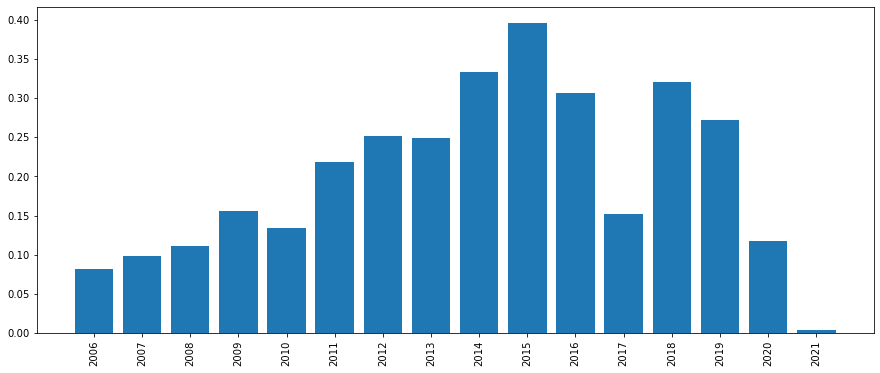

In [144]:

import matplotlib.pyplot as plt
rev_date = df.review_date.unique()
weighted_rating = []
for rev in rev_date:
    count = company_date_counts[rev]
    rating = average_ratings_review_date[rev]
    weighted_rating.append(count * rating)
    
sorted_vals = sorted(list(zip(weighted_rating, rev_date)))
x = [val[1] for val in sorted_vals]
y = [val[0] for val in sorted_vals]

plt.figure(figsize=(15,6))
plt.bar(x, y)
plt.xticks(rotation=90, ticks=date_range);

>The review date tends to fluctuate between the years. In the year 2015 it is shown to have the highest peak of rating. Years 2014,2016, and 2018 also seem to have higher rating correlation. This is interesting because these years are consistant except for in 2017 there is a drop. I am going to group these years together but leave out 2017 so it does not lower the higher averages. It looks like most ratings are consistant with a range of years and then shifts and then stays the same and then shifts. Interesting to see that they stay pretty consistent with their groupsings.

### creating bins for the review date according to the vizualization above 

In [145]:
#smallest rating
first_bin_date = (2006, 2007, 2008, 2010, 2017, 2020, 2021)
first_bin_date

(2006, 2007, 2008, 2010, 2017, 2020, 2021)

In [146]:
#medium rating
second_bin_date = (2009, 2011, 2012, 2013, 2019)
second_bin_date

(2009, 2011, 2012, 2013, 2019)

In [147]:
#higher rating
third_bin_date = (2014, 2015, 2016, 2018)
third_bin_date

(2014, 2015, 2016, 2018)

In [148]:
#setting variable to low rating group
bin_a_index = df[df.review_date.isin(first_bin_date)].index
df.at[bin_a_index, 'review_date_bin'] = 'a'

In [149]:
#setting variable to medium rating group
bin_b_index = df[df.review_date.isin(second_bin_date)].index
df.at[bin_b_index, 'review_date_bin'] = 'b'

In [150]:
#setting variable to higher rating group
bin_c_index = df[df.review_date.isin(third_bin_date)].index
df.at[bin_c_index, 'review_date_bin'] = 'c'

## Determining how impactful the cocoa percentage is to the target (rating)

In [151]:
#breaking down cocoa percent to 2 different groups 
df['cocoa_bucket'] = pd.qcut(df['cocoa_percent'], q=2, duplicates='drop')

In [152]:
#looking into the value counts according to the groups of cocoa percentage 
df['cocoa_bucket'].value_counts()

(45.999, 70.0]    1265
(70.0, 99.0]       966
Name: cocoa_bucket, dtype: int64

In [153]:
#looking into the mean rating according to the groups of cocoa percentage
df.groupby('cocoa_bucket').mean()['rating']

cocoa_bucket
(45.999, 70.0]    3.250672
(70.0, 99.0]      3.148033
Name: rating, dtype: float64

In [154]:
#breaking the ratings into groups of high and low using 1 (above 3) and 0 (anything below 3)
df['rating_class'] = [1 if r >= 3 else 0 for r in df['rating']]

### Vizualizing the distribution of ratings according to the cocoa distribution

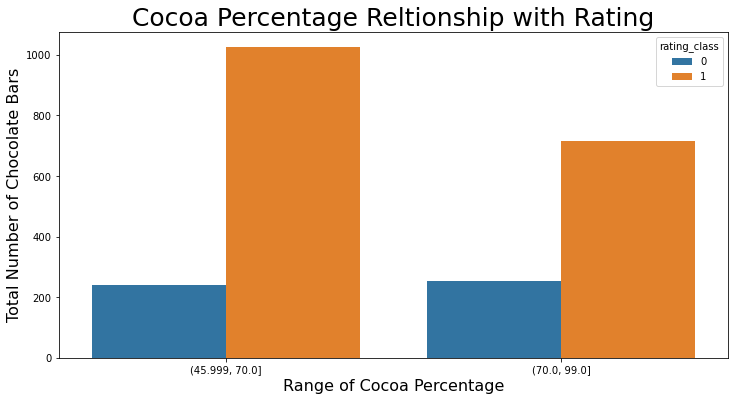

In [155]:
fig, ax = plt.subplots(figsize = (12,6))
sns.countplot(x='cocoa_bucket',data=df, hue='rating_class', ax=ax)

plt.xlabel('Range of Cocoa Percentage', fontsize=16)
plt.ylabel('Total Number of Chocolate Bars', fontsize=16)
plt.title('Cocoa Percentage Reltionship with Rating', fontsize=25);

* the X-label indicates the range of cocoa percentage 
* the Y-label indicated the number of times each cocoa percentage
* the Hue indicates 1 as a High Rating and 0 as a Low Rating


## Determining the relationship of comapny manufacturer with the target (rating).

In [156]:
# manufacturer and rating
average_ratings_company_manufacturer = df.groupby('company_manufacturer')['rating'].mean().sort_values().to_dict()


In [157]:
company_manufacturer_counts = df['company_manufacturer'].value_counts(normalize=True).to_dict()


In [158]:
#creating a for loop to get the weighted rating of the company manufacturer
import matplotlib.pyplot as plt
comp_manufacturer = df['company_manufacturer'].unique()
weighted_rating = []
for comp in comp_manufacturer:
    count = company_manufacturer_counts[comp]
    rating = average_ratings_company_manufacturer[comp]
    weighted_rating.append(count * rating)
    
sorted_vals = sorted(list(zip(weighted_rating, comp_manufacturer)))
x = [val[1] for val in sorted_vals]
y = [val[0] for val in sorted_vals]


In [159]:
df['comp_manufact_bin'] = 1

In [160]:
first_bin = x[:200]


bin_a_index = df[df.company_manufacturer.isin(first_bin)].index
df.at[bin_a_index, 'comp_manufact_bin'] = 'a'

In [161]:
second_bin = x[200:350]

bin_b_index = df[df.company_manufacturer.isin(second_bin)].index
df.at[bin_b_index, 'comp_manufact_bin'] = 'b'

In [162]:
third_bin = x[350:451]

bin_c_index = df[df.company_manufacturer.isin(third_bin)].index
df.at[bin_c_index, 'comp_manufact_bin'] = 'c'

In [163]:
fourth_bin = x[451:]

bin_d_index = df[df.company_manufacturer.isin(fourth_bin)].index
df.at[bin_d_index, 'comp_manufact_bin'] = 'd'

In [164]:
#checking values to ensure that the binning worked
df.comp_manufact_bin.value_counts()

d    803
c    646
b    506
a    276
Name: comp_manufact_bin, dtype: int64

### Vizualizing the distribution of ratings according to the company manufacturer 

<AxesSubplot:xlabel='comp_manufact_bin', ylabel='count'>

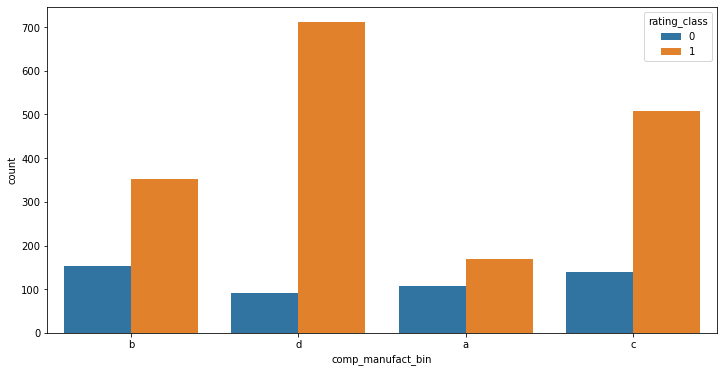

In [165]:
fig, ax = plt.subplots(figsize = (12,6))
sns.countplot(data=df, x='comp_manufact_bin', hue='rating_class', ax=ax)


>The rating of 3 or above is occuring more often than less than 3 in all of the manufacture bins. The grouping with ratings of 3 or above occuring the most often is group d and the group with the least amount is group a. Group a tends to encompass a lot of countries that do not have the right climate to allow cocoa plants to prosper, group d tends to have countries who have super warm climates and are closest to the equator which is prime condition for cocoa plants to grow and survive.

In [169]:
df.to_csv('../../../data/EDA.csv', index=False)